In [1]:
import os
import re
import io
import time
import math
import urllib
import zipfile
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
def load_shiller():
    # Notes on Shiller's dividend data:
    # Until 1926, data was annual and interpolated to be monthly
    # From 1926 onwards, data is quarterly and interpolated to be monthly
    # Starting from 1999, you can see the interpolation happening in the cell formulas
    # To get the actual amount of dividends to add each quarter, we need to subtract the previous 3 quarters
    # This is because of the weird interpolation to make the data monthly
    url = "http://www.econ.yale.edu/~shiller/data/ie_data.xls"
    response = requests.get(url)
    xls_file_content = io.BytesIO(response.content)

    # Map months to the first day of the month
    df_shiller = pd.read_excel(xls_file_content, sheet_name='Data', header=7, nrows=1831, dtype={'Date': 'string'})
    df_shiller['Date'] = df_shiller['Date'].apply(lambda x: x.replace('.', '-'))
    df_shiller.index = df_shiller['Date'].apply(lambda x: re.sub('-1$', '-10', x))
    df_shiller.index = pd.to_datetime(df_shiller.index)
    
    return df_shiller

In [3]:
def load_gspc():
    # ^GSPC is price only index, which has data back to 1928
    # Note we have to use yf.download() to access the full price history of ^GSPC
    # yf.download() is not usually wanted because the Close column is price only, unlike yf.Ticker()
    df_gspc = yf.download('^GSPC', progress=False)[['Close']]
    
    # We will only be able to go up to 2023-06-16 currently, as it is the last dividend date
    # in Shiller's data as of 2024-01-24. This will change over time, but it doesn't matter
    # because we fill in data after that with SPY's actual data
    df_gspc = df_gspc.loc[df_gspc.index <= datetime(2023, 6, 16)].copy()
    
    return df_gspc

In [4]:
def load_schwert():
    # Get the data
    url = 'https://www.billschwert.com/stkdatd.zip'
    filehandle, _ = urllib.request.urlretrieve(url)
    zip_file_object = zipfile.ZipFile(filehandle, 'r')
    first_file = zip_file_object.namelist()[0]
    file = zip_file_object.open(first_file)
    content = io.BytesIO(file.read())
    
    # Return column is the Capital Gain Return column + Dividend Yield column
    # This gives a decent estimate of a total return index, but we can do better using Shiller's dividend data
    df = pd.read_csv(content, 
                     sep="\\s+",
                     header=None, 
                     names=['Date', 'Return', 'Capital Gain Return', 'Dividend Yield'])
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    df = df.set_index('Date')
    df = df.loc[(df.index >= datetime(1885, 3, 20))            # First dividend date in Schwert's data
                & (df.index <= datetime(1962, 6, 16))].copy()  # Last dividend date in Schwert's data
    df['Close'] = (df['Capital Gain Return'] + 1).cumprod()
    df.loc[df.index[0], 'Close'] = 1
    
    # Prior to 1952, the market was open on Saturdays.
    # We drop the Saturdays to make calculations easier and because Yahoo Finance ^GSPC data drops Saturdays.
    # The effect on returns is still included though, since we calculate the close column before dropping Saturdays
    df = df.loc[df.index.dayofweek != 5].copy()
    
    return df

In [5]:
def calculate_adjusted_closes(closes, dividends):
    """
    Calculates the adjusted close, only taking into account quarterly dividends.
    
    Args:
        closes (np.ndarray): A numpy array of close values.
        dividends (np.ndarray): A numpy array of dividends. Must have no NaNs, and same length as closes.
    
    Returns:
        np.ndarray: The adjusted close values.
    """
    
    initial_close = closes[0]
    adjusted_closes = np.full(closes.shape[0], initial_close)
    prev_close = initial_close
    prev_adjusted = initial_close
    
    # Start on second close
    for i in range(1, closes.shape[0]):
        current_close = closes[i]
        new_adjusted = prev_adjusted * (current_close / (prev_close - dividends[i]))
        adjusted_closes[i] = new_adjusted
        
        prev_close = current_close
        prev_adjusted = new_adjusted
            
    return adjusted_closes

In [6]:
def calculate_accumulated_dividends(closes, adjusted_closes, daily_dividends, dividend_days_mask):
    """
    Calculates the accumulated dividends for the given closes and daily dividends.
    
    Args:
        closes (np.ndarray): A numpy array of price-only close values.
        adjusted_closes (np.ndarray): A numpy array of close values with quarterly dividends added.
        daily_dividends (np.ndarray): A numpy array of daily dividends. Must have no NaNs, and same length as closes.
        dividend_days_mask (np.ndarray): A numpy array containing True on days when there was a quarterly dividend.
    
    Returns:
        np.ndarray: The accumulated dividends.
    """
        
    accumulator = 0
    multiplier = 1
    accumulated_values = np.zeros(closes.shape[0])
    
    for i in range(closes.shape[0]):
        if dividend_days_mask[i]:
            accumulator = 0
            multiplier = adjusted_closes[i] / closes[i]
        else:
            accumulator += daily_dividends[i]
            
        accumulated_values[i] = accumulator * multiplier
        
    return accumulated_values

In [7]:
def calculate_total_return_index(df_schwert, df_gspc, df_shiller, expense_ratio=0.000945):
    """
    Calculates the total return index for the given input dfs and expense ratio.
    
    Args:
        df_schwert (pd.DataFrame):        A dataframe containing Schwert's data with a Close column.
        df_gspc (pd.DataFrame):           A dataframe containing ^GSPC data with a Close column.
        df_shiller (pd.DataFrame):        A dataframe containing Shiller's dividend data with the column named 'D'.
        expense_ratio (float), optional:  The expense ratio to apply over the entire time period.
    
    Returns:
        A dataframe containing the following columns:
            Close                 The price-only close values
            Adjusted Close        The adjusted/total return close values
            Return                The daily percent change of the adjusted close values
            Dividend              The quarterly dividends
            Elapsed Trading Days  The number of trading days in the preceding quarter
            Daily Dividend        The approximate daily dividend amount.
            Accumulated Dividend  The accumulated daily dividend over a quarter.
    """
        
    # Merge df_schwert and df_gspc before adding dividends
    # Note that we use Schwert's data for overlap between df_schwert and df_gspc's data
    # This is because of the caclulation we do in the following lines to get the starting price
    df = df_schwert[['Close']].pct_change().merge(df_gspc[['Close']].pct_change(), 
                                                  how='outer',
                                                  left_index=True, 
                                                  right_index=True)
    df['Return'] = df[['Close_x', 'Close_y']].bfill(axis=1).iloc[:, 0]
    
    # Since our data only has percent changes now, not close, we need to work backwards
    # to get the starting close price. This is important in the Accumulated Dividend calculation.
    # We do this by dividing the actual close for ^GSPC on 1962-6-15, which is 55.89, by the cumulative return
    # for Schwert's data, which is 12.90. You could do this in code through the following:
    # df['Close'] = (df['Return'] + 1).cumprod()
    # gspc_value = df_gspc.loc[df_gspc.index == df.index[-1], 'Close'].iloc[0]
    # starting_price = gspc_value / df_schwert.iloc[-1]['Close']
    # df['Close'] = (df['Return'] + 1).cumprod() * starting_price
    # df.loc[df.index[0], 'Close'] = starting_price
    # However, since the starting price is static, we can just calculate it beforehand
    # The value turns out to be 4.332469, which is close to the 4.38 in Shiller's data for 1885-3
    STARTING_PRICE = 4.332469482434323
    df['Close'] = (df['Return']+1).cumprod() * STARTING_PRICE
    df.loc[df.index[0], 'Close'] = STARTING_PRICE
    
    # Initialize columns
    df['Dividend'] = np.NaN
    df['Adjusted Close'] = df['Close']
    

    # Now we start calculating the actual quarterly dividends from the D column in Shiller, which is the
    # monthly interpolated dividends. The following line gets quarterly months, starting from 1871-3
    df_dividend = df_shiller[['D']][2:][::3].dropna().copy() 
    df_dividend['Dividend'] = np.NaN  # This will be the column for the actual quarterly dividend amount

    # We have to fill out the first year manually before we can use the recursive formula
    first_year_dividend = df_dividend.loc[datetime(df_dividend.index[0].year, 12, 1)].iloc[0] / 4
    df_dividend.iloc[:4, 1] = first_year_dividend

    prev_3 = first_year_dividend
    prev_6 = first_year_dividend
    prev_9 = first_year_dividend
    # [4:] is so we start on the first quarter of the second year
    for idx, row in df_dividend[4:].iterrows():
        quarterly_dividend = row['D'] - (prev_3 + prev_6 + prev_9)
        df_dividend.at[idx, 'Dividend'] = quarterly_dividend

        prev_9 = prev_6
        prev_6 = prev_3
        prev_3 = quarterly_dividend

    # Now we have to map the dates in df_dividend to the dates in df
    # We do this by finding the third fridays of the quarterly months in df
    # The market close during WWI from 1914-7-30 to 1914-12-12 messes with the [::3] to get
    # quarterly months, so we split the date range up and drop 1914-9 from df_dividend
    # ffill is used because if the third friday isn't a trading day, the day before is used
    df_dividend = df_dividend.drop(datetime(1914, 9, 1))

    third_fridays_pre_war = pd.date_range(df.index[0], datetime(1914, 7, 30), freq='WOM-3FRI')
    third_fridays_post_war = pd.date_range(datetime(1914, 12, 12), df.index[-1], freq='WOM-3FRI')
    dividend_dates_pre_war = df.iloc[df.index.get_indexer(third_fridays_pre_war, 'ffill')[::3]].index
    dividend_dates_post_war = df.iloc[df.index.get_indexer(third_fridays_post_war, 'ffill')[::3]].index
    dividend_dates = dividend_dates_pre_war.append(dividend_dates_post_war)

    df.loc[dividend_dates, 'Dividend'] = df_dividend.loc[df_dividend.index >= datetime(df.index[0].year, 
                                                                                       df.index[0].month, 1), 
                                                         'Dividend'].values
        
    # This isn't used in the code, but it can be used to comapare the accuracy of dividends with the following:
    # https://www.spglobal.com/spdji/en/indices/equity/sp-500-dividend-points-index-quarterly/#overview
    # df['Dividend Point Index'] = df['Dividend']
    # df.loc[df.index[~df.shift()['Dividend'].isna()], 'Dividend Point Index'] = 0
    # df['Dividend Point Index'] = df['Dividend Point Index'].interpolate()
    # Note that this is the same as Accumulated Dividend, but it resets to 0 the day after the quarterly dividend 
    # instead of on the day of the quarterly dividend

    
    # Calculate adjusted closes using only quarterly dividends
    df['Adjusted Close'] = calculate_adjusted_closes(df['Close'].values, df['Dividend'].fillna(0).values)
        
    # Individual companies in the S&P 500 will have dividend dates spread out evenly over the month,
    # but ETFs like SPY only distribute every quarter. This effect can be seen in the link mentioned above:
    # https://www.spglobal.com/spdji/en/indices/equity/sp-500-dividend-points-index-quarterly/#overview
    # We adjust for this by approximating the daily dividend amount as the quarterly dividend distributed 
    # evenly over every day of the quarter. A formula is then used to adjust the close again using the daily dividend.
    df['Daily Dividend'] = df['Dividend']
    df['Idx'] = np.arange(len(df))
    df['Elapsed Trading Days'] = np.NaN
    
    # Get the number of trading days between each dividend distribution. Using 63 also works as an approximation
    quarterly_dividend_indices = df.loc[df['Dividend'].notna()].index
    df.loc[quarterly_dividend_indices[1:], 'Elapsed Trading Days'] = df.loc[df['Daily Dividend'].notna(), 'Idx'] - \
                                                                df.loc[df['Daily Dividend'].notna(), 'Idx'].shift() - 1
    df['Elapsed Trading Days'] = df['Elapsed Trading Days'].bfill()
    df['Daily Dividend'] = df['Daily Dividend'].bfill() / df['Elapsed Trading Days']
    
    # Add back in accumulated dividends
    df['Accumulated Dividend'] = calculate_accumulated_dividends(df['Close'].values,
                                                                 df['Adjusted Close'].values,
                                                                 df['Daily Dividend'].values,
                                                                 df['Dividend'].notna().values)
    df['Adjusted Close'] += df['Accumulated Dividend']
    
    
    # Add in expense ratio and make adjusted close start at 1 for easier comparisons
    df['Return'] = df['Adjusted Close'].pct_change() - (expense_ratio / 252)
    df['Adjusted Close'] = (df['Return'] + 1).cumprod()
    df.loc[df.index[0], 'Adjusted Close'] = 1
    
    
    # Returning like this is an easy way to change column order to be a bit more logical
    return df[['Close', 
               'Adjusted Close', 
               'Return', 
               'Dividend', 
               'Elapsed Trading Days',
               'Daily Dividend', 
               'Accumulated Dividend']]

In [8]:
def update_with_spy(adjusted_close):
    """
    Adds in recent SPY data to the end of the provided series.
    
    Args:
        adjusted_close (pd.Series): A series containing adjusted close data to augment with SPY data.
    
    Returns:
        pd.Series: A series with adjusted close data until present day.
    """
    
    if adjusted_close is not None:
        if not isinstance(adjusted_close, pd.Series):
            raise Exception('Adjusted close data must be a pandas Series.')

        if adjusted_close.isna().sum() != 0:
            raise Exception('Adjusted close data should not contain NaNs.')
    
    df_adjusted_close = pd.DataFrame({'Adjusted Close': adjusted_close})
    
    # Using yf.Ticker gets adjusted close even though it names the column 'Close'
    df_spy = yf.Ticker('SPY').history(period='max')
    df_spy = df_spy[['Close']]
    df_spy.index = df_spy.index.tz_localize(None)
    
    df = df_adjusted_close.pct_change().merge(df_spy.pct_change(), 
                                              how='outer', 
                                              left_index=True, 
                                              right_index=True)
    df['Adjusted Close'] = df[['Adjusted Close', 'Close']].bfill(axis=1).iloc[:, 0]
    df['Adjusted Close'] = (df['Adjusted Close'] + 1).cumprod()
    df.loc[df.index[0], 'Adjusted Close'] = 1
    df = df[['Adjusted Close']]
    
    return df

In [9]:
def plot_comparison(series, other_series=None, series_name='First Series', other_series_name='SPY'):
    if other_series is None:
        other_df = yf.Ticker('SPY').history(period='max')
        other_df.index = other_df.index.tz_localize(None)
        other_series = other_df['Close']  # This is Adjusted Close. yfinance just doesn't name it as such
    
    df = series.to_frame().merge(other_series.to_frame(), how='inner', left_index=True, right_index=True)

    df['Close_x'] = (df.iloc[:, 0].pct_change() + 1).cumprod()
    df.loc[df.index[0], 'Close_x'] = 1
    
    df['Close_y'] = (df.iloc[:, 1].pct_change() + 1).cumprod()
    df.loc[df.index[0], 'Close_y'] = 1

    mpl.rcParams['figure.dpi'] = 300  # Makes plot higher quality
    fig = plt.figure(figsize = (15, 5))
    fig.patch.set_facecolor('white')
    plt.plot(df.index, df['Close_x'], color='blue', label=series_name)
    plt.plot(df.index, df['Close_y'], color='red', label=other_series_name)
    plt.title(f'Comparison Dates: ' + df.index[0].strftime('%b %Y') + ' - ' + \
                  df.index[-1].strftime('%b %Y'), fontsize=14)
    
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Close', fontsize=14)
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()

    fig = plt.figure(figsize = (15, 5))
    fig.patch.set_facecolor('white')
    plt.plot(df.index, df['Close_x'] / df['Close_y'], color='blue')
    plt.title(f'Comparison Dates: ' + df.index[0].strftime('%b %Y') + ' - ' + \
              df.index[-1].strftime('%b %Y'), fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(f'{series_name} / {other_series_name}', fontsize=14)
    plt.show()
    
    print(f'Cumulative return of {series_name}: {df["Close_x"].iloc[-1]}')
    print(f'Cumulative return of {other_series_name}: {df["Close_y"].iloc[-1]}')

In [10]:
def plot_adjusted_close(df):
    mpl.rcParams['figure.dpi'] = 300  # Makes plot higher quality
    fig = plt.figure(figsize = (15, 5))
    fig.patch.set_facecolor('white')
    plt.plot(df.index, df['Adjusted Close'], color='blue')
    plt.title(f'Adjusted Close Values from ' + df.index[0].strftime('%b %Y') + ' - ' + \
                  df.index[-1].strftime('%b %Y'), fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Adjusted Close', fontsize=14)
    plt.yscale('log')
    plt.show()
    
    print(f'Cumulative return: {df["Adjusted Close"].iloc[-1]}')

In [11]:
df_gspc = load_gspc()
df_schwert = load_schwert()
df_shiller = load_shiller()

In [12]:
# df contains data until June 16, 2023
df = calculate_total_return_index(df_schwert, 
                                  df_gspc, 
                                  df_shiller, 
                                  expense_ratio = 0.000945)

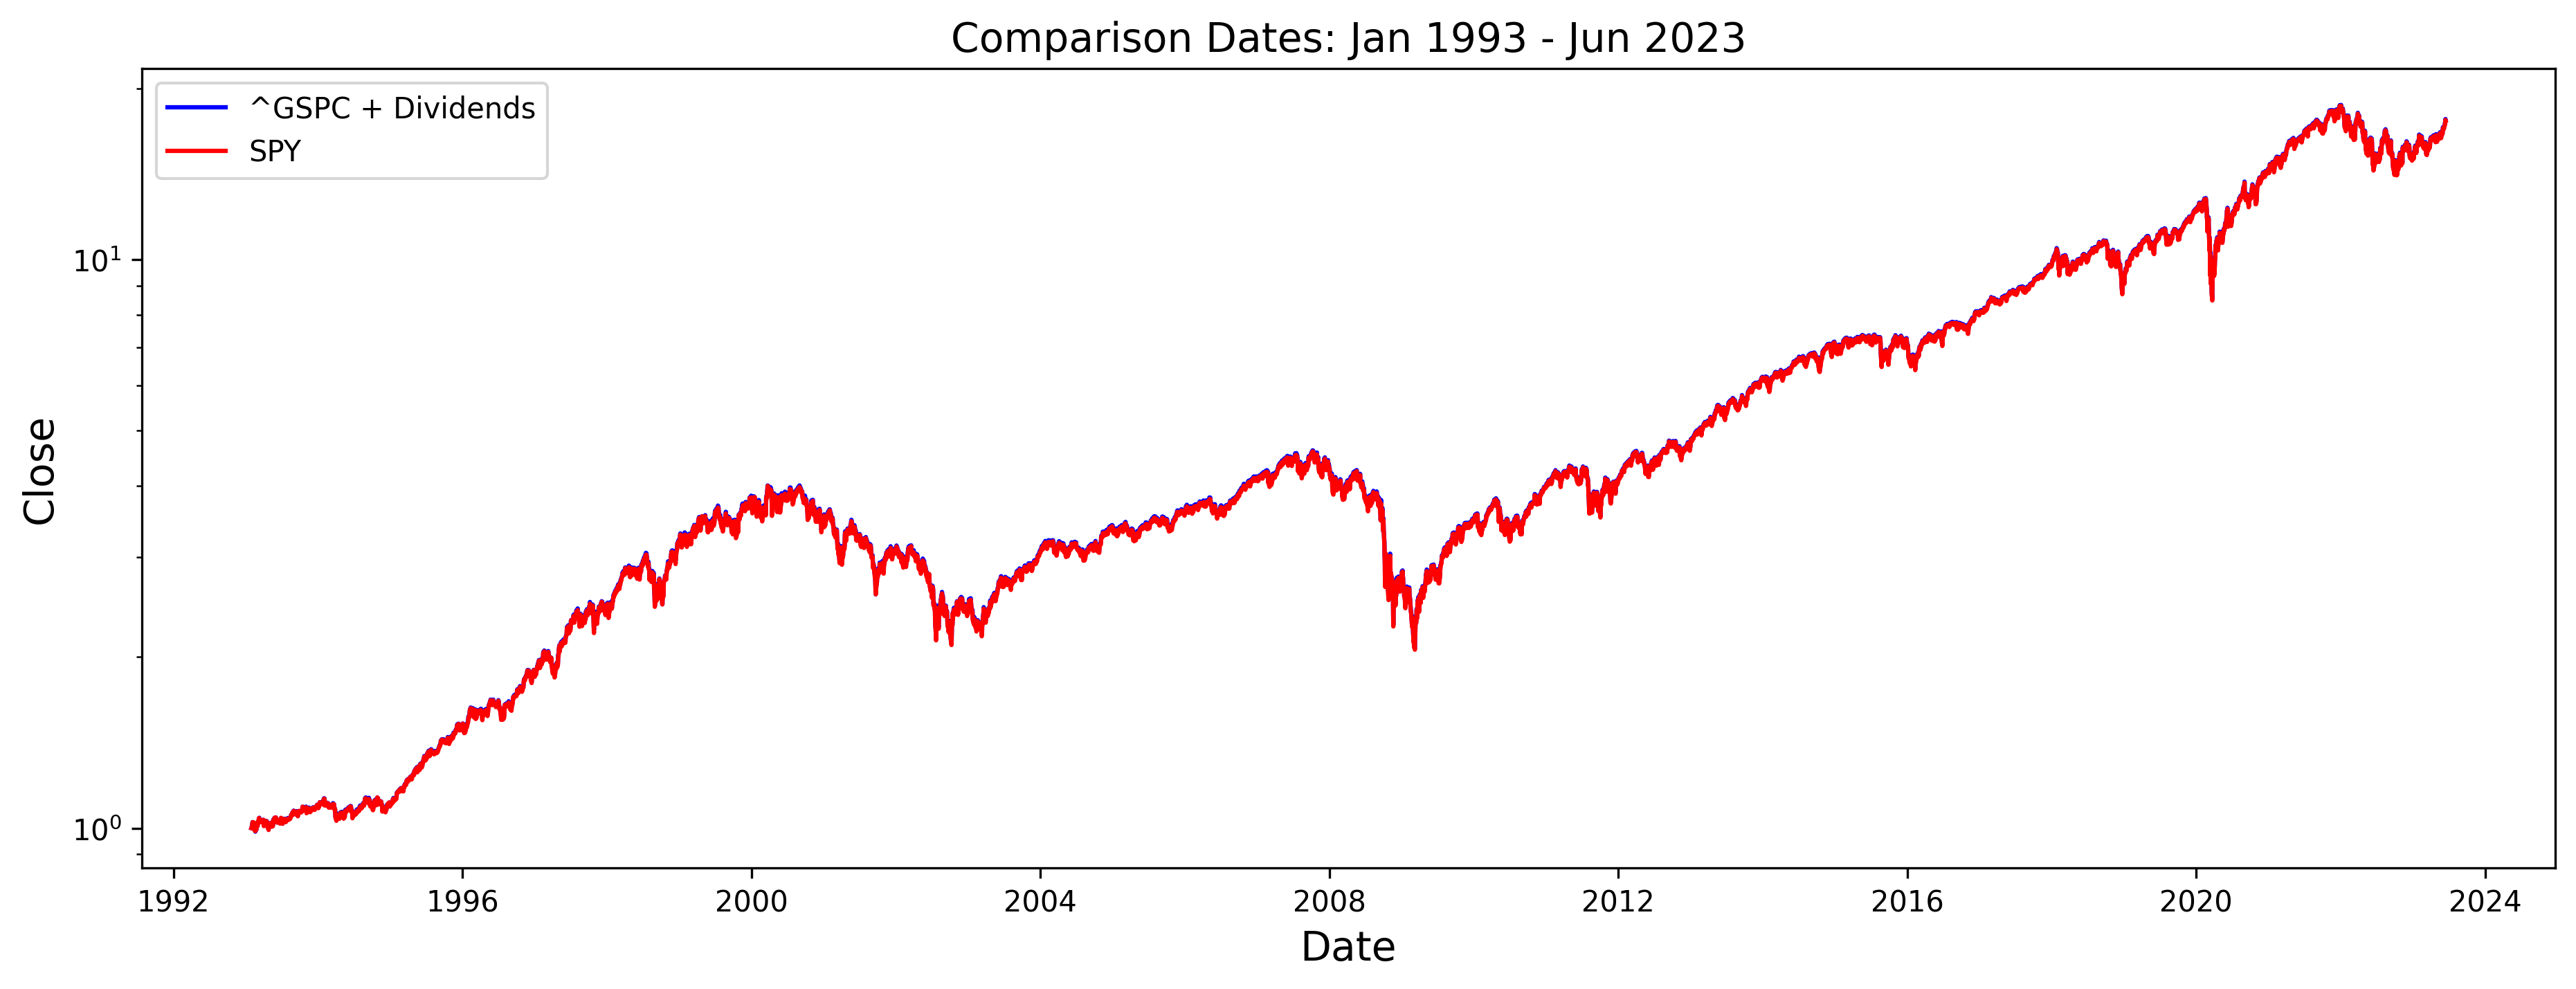

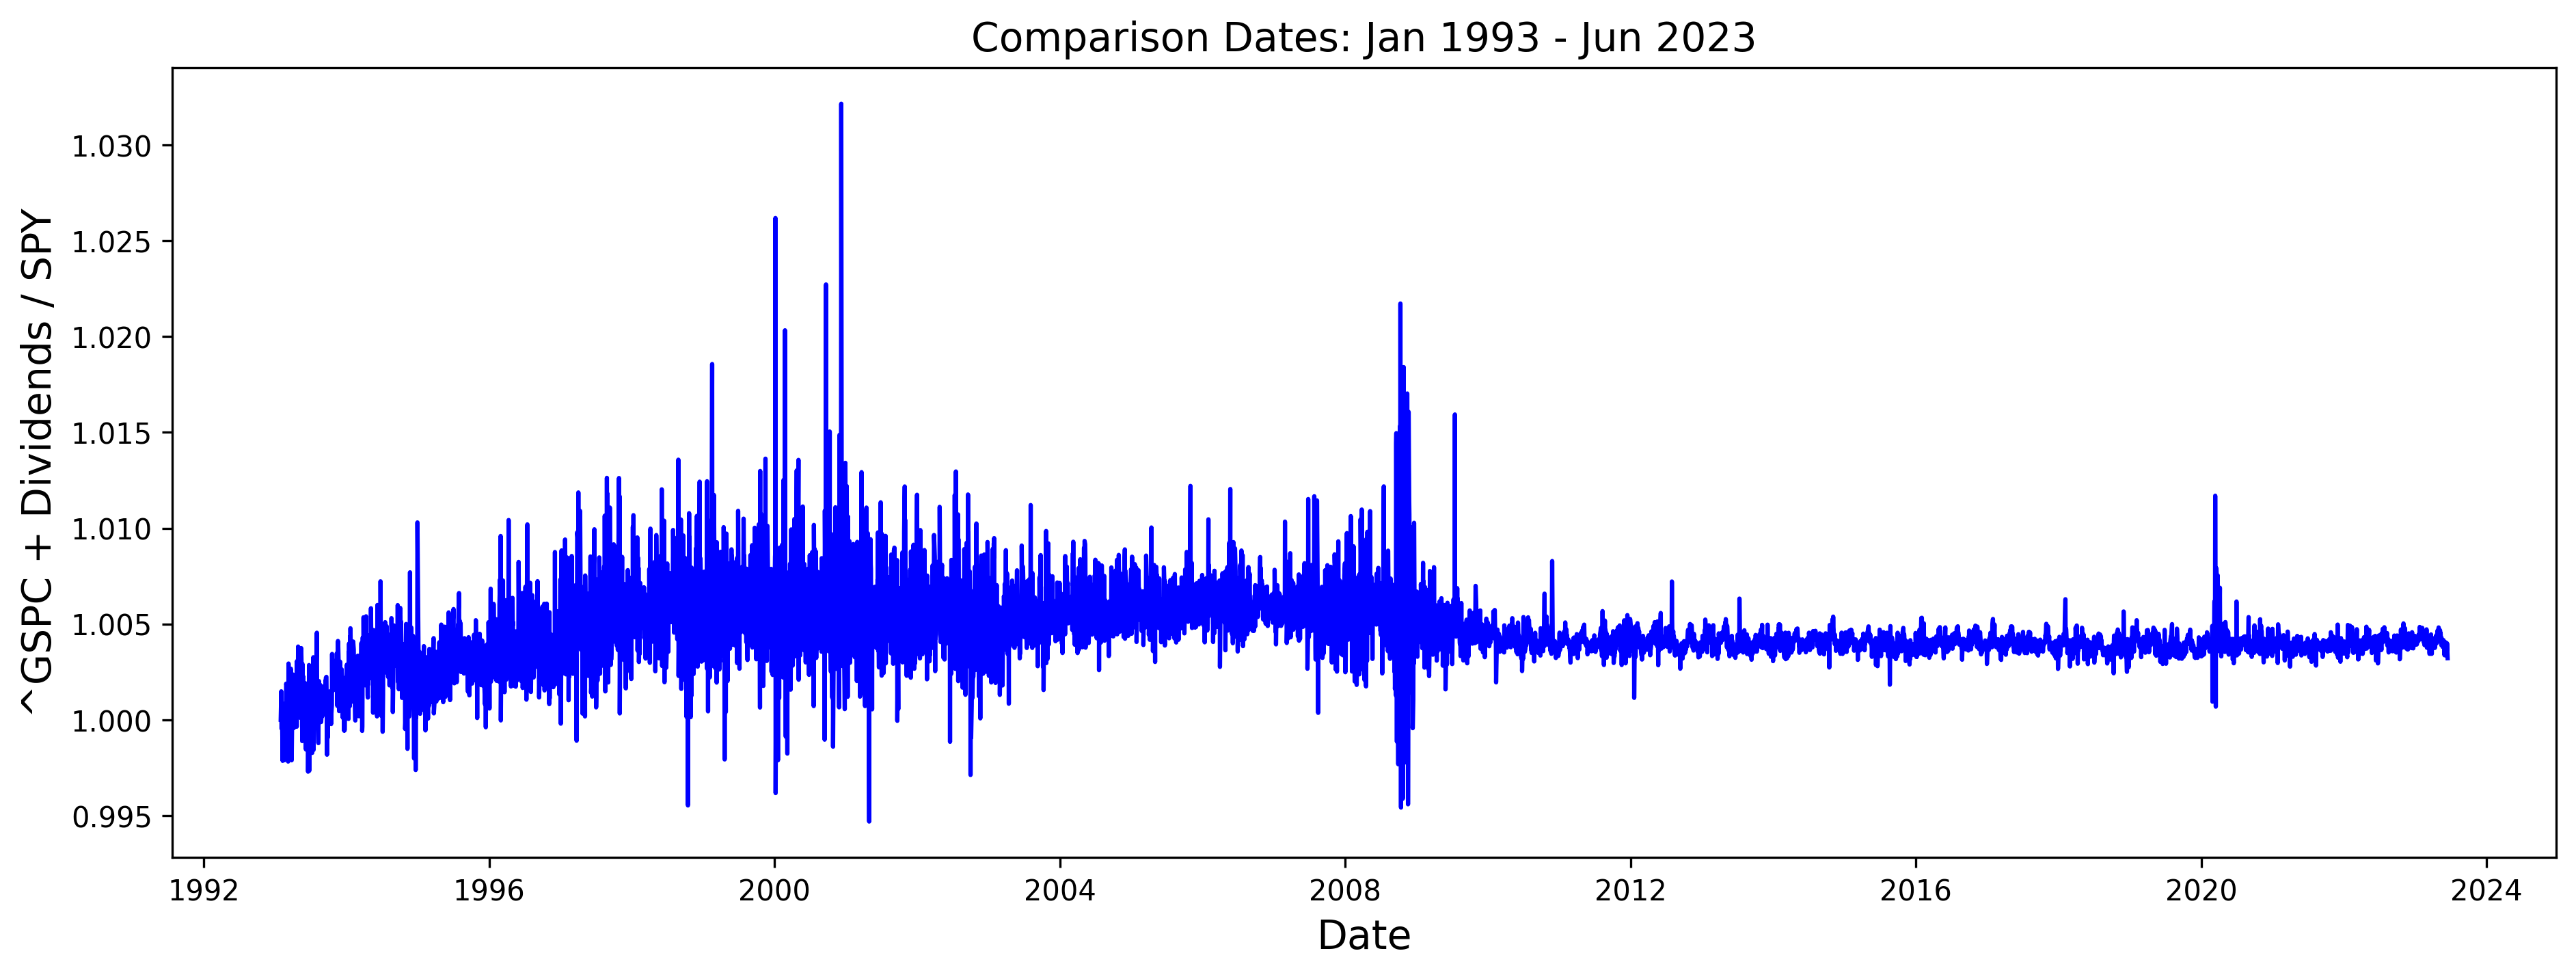

Cumulative return of ^GSPC + Dividends: 17.61421457958116
Cumulative return of SPY: 17.55777018954422


In [13]:
# Don't use the updated data for comparison because the most recent data is exactly the same as SPY
plot_comparison(df['Adjusted Close'], series_name = '^GSPC + Dividends')  

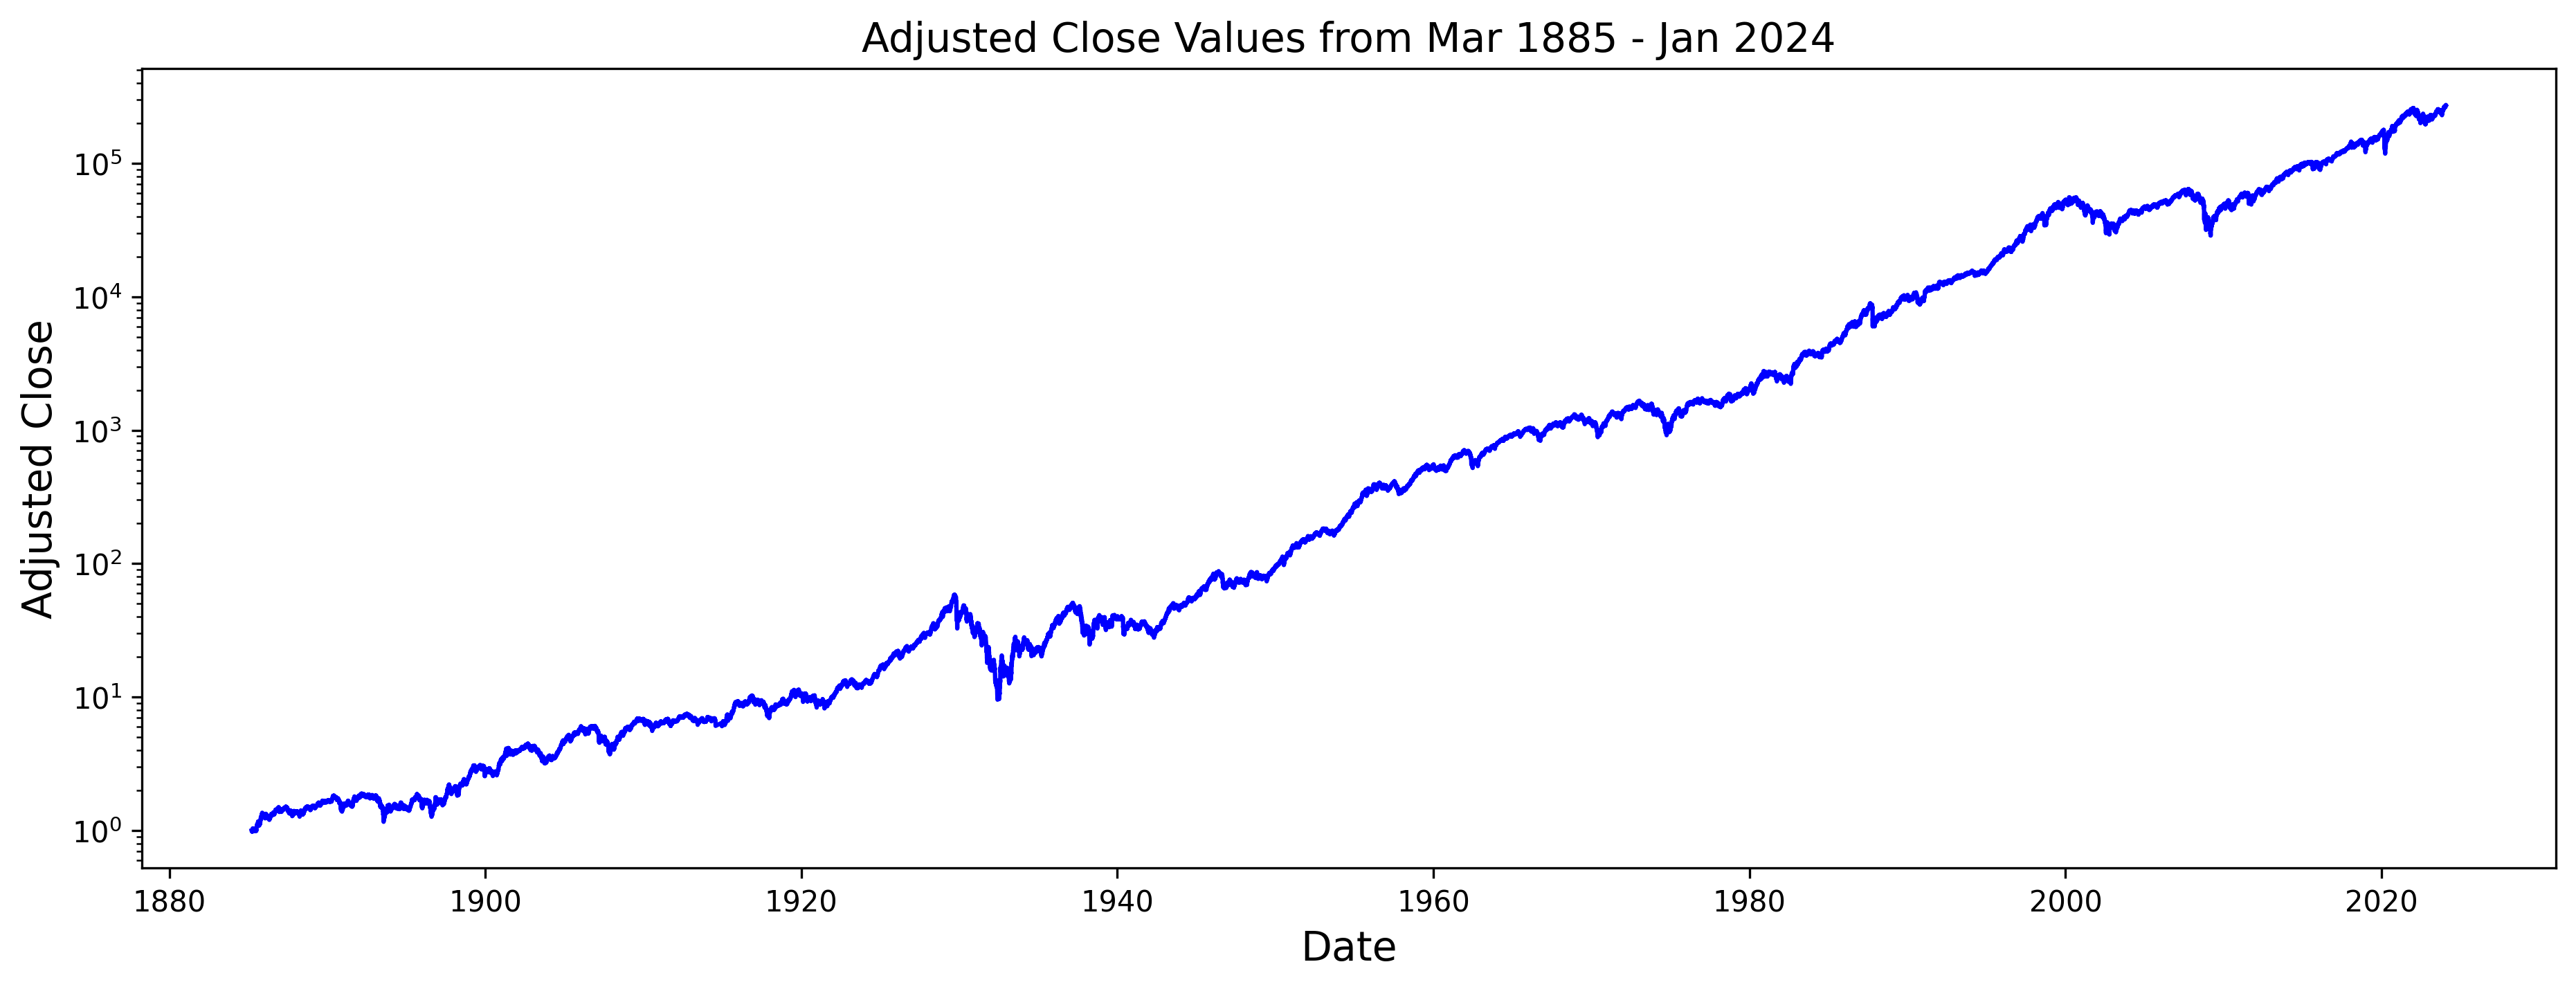

Cumulative return: 273762.2703904687


In [14]:
df_current = update_with_spy(df['Adjusted Close'])  # Update the most recent dates with SPY data
plot_adjusted_close(df_current)

In [15]:
# Downloads dfs
os.makedirs('../data', exist_ok=True)
df_current.to_csv('../data/adjusted_close_data.csv')
df.to_csv('../data/full_data.csv')

In [16]:
# Uncomment to run a line profiler to measure performance
# import line_profiler
# %load_ext line_profiler
# %lprun -u 1e-3 -f calculate_total_return_index calculate_total_return_index(df_schwert, df_gspc, df_shiller)